In [ ]:
# Standard library imports.
from datetime import datetime, timedelta

# Related third party imports.
import requests
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (16,8)

# Local application/library specific imports.


# Download link traffic between firstDay and lastDay
# tuple, datetime, datetime -> ('bost-cr5','2/1/1'), datetime(2016,1,1,0,0,30), datetime(2016,2,1,0,0,0)
def download_link_traffic(link: tuple, start_date: datetime,
                          end_date: datetime) -> pd.DataFrame:
    # Empty list for the data
    traffic_data = []

    current_date = start_date
    while current_date < end_date:
        # The URL contains the link and time info.
        url = 'https://my.es.net/graphql?query={query:interface(device:"' + str(
            link[0]) + '",interface:"' + str(
                link[1]) + '"){traffic(beginTime:"' + current_date.isoformat(
                ) + '" endTime:"' + (current_date + timedelta(days=1)
                                     ).isoformat() + '"){points}}}&raw'

        # Downloading the data
        data = requests.get(url, verify=False)
        # Converting it to JSON
        json_data = data.json()

        if json_data['data']['query']['traffic']:
            # We have to go down some levels to get the data.
            # -> json_data['data']['query']['traffic']['points']
            traffic_data.extend(
                json_data['data']['query']['traffic']['points'])

        #moving to the next day
        current_date = current_date + timedelta(days=1)
    return pd.DataFrame(traffic_data, columns=['date', 'in', 'out'])

def changeDateFormat(df):
    # Oneliner to convert the UNIX timestamp to readable format
    func = lambda x: datetime.utcfromtimestamp(int(x)/1000).strftime('%Y-%m-%d %H:%M:%S')
    # Exchanging the timestamps
    df['date'] = df['date'].apply(func)
    return df


In [ ]:
# Test the traffic download...
link = ("lasv-cr6", "nnss_se-181")
a, b = datetime(2021,10,1,0,0,30), datetime(2021,10,4,0,0,0)
df = download_link_traffic(link, a, b)
df = changeDateFormat(df)
#df.to_csv('C:\Elod\MSc_Onlab2\datasets\simple_link_traffic.csv', index=False)

/usr/local/lib/python3.7/dist-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)
/usr/local/lib/python3.7/dist-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)
/usr/local/lib/python3.7/dist-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


In [ ]:
df.describe()

,in,out
count,7.879000e+03,7.919000e+03
mean,9.402068e+07,8.462114e+07
std,8.630980e+07,1.008637e+08
min,2.277754e+07,1.110617e+07
25%,7.044925e+07,4.661936e+07
50%,7.915267e+07,6.394983e+07
75%,9.608585e+07,9.178736e+07
max,1.179938e+09,1.488685e+09


/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


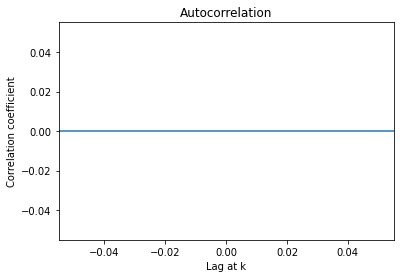

In [ ]:
df['out'] = df['out']/10**9

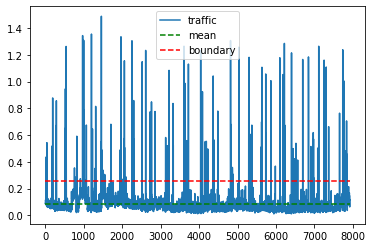

In [ ]:
df['out'].plot(label='traffic')
x = [0, len(df)]
y = [np.mean(df['out']), np.mean(df['out'])]
plt.plot(x, y, 'g--', label='mean')
x = [0, len(df)]
y = [3*np.mean(df['out']), 3*np.mean(df['out'])]
plt.plot(x, y, 'r--', label='boundary')
plt.legend()

Lets define spikes from mean*3

In [ ]:
dataset = df['out']
dataset

0       0.110819
1       0.089974
2       0.108715
3       0.084453
4       0.088943
          ...   
7915    0.136223
7916    0.097971
7917    0.071027
7918    0.063522
7919    0.117177
Name: out, Length: 7920, dtype: float64

In [ ]:
dataset.fillna(np.mean(dataset), inplace=True)
sum(dataset.isna())

0

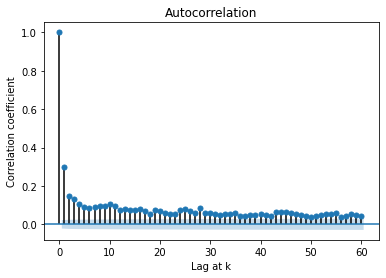

In [ ]:
from statsmodels.graphics import tsaplots

fig = tsaplots.plot_acf(dataset, lags=60)
plt.xlabel("Lag at k")
plt.ylabel("Correlation coefficient")
plt.show()

In [ ]:
from sklearn.model_selection import train_test_split
dataset_train, dataset_test = train_test_split(dataset, test_size=0.1, shuffle=False)
print(dataset_train)

0       0.110819
1       0.089974
2       0.108715
3       0.084453
4       0.088943
          ...   
7123    0.080468
7124    0.045926
7125    0.058625
7126    0.043427
7127    0.044837
Name: out, Length: 7128, dtype: float64


In [ ]:
training_set = dataset_train.values
training_set = np.reshape(training_set, (-1, 1))
training_set

array([[0.11081921],
       [0.08997357],
       [0.10871498],
       ...,
       [0.05862543],
       [0.0434273 ],
       [0.04483664]])

In [ ]:
X_train = []
y_train = []
WINDOW_SIZE = 120

for i in range(WINDOW_SIZE,len(training_set)):
  X_train.append(training_set[i-WINDOW_SIZE:i, 0])
  y_train.append(training_set[i, 0])

X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

In [ ]:
import keras
import keras.models
import keras.layers

model = keras.models.Sequential([
    keras.layers.LSTM(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.Dropout(0.2),
    keras.layers.LSTM(20),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(1)
])

model.compile(optimizer = 'adam', loss = 'mean_squared_error')

In [ ]:
model.fit(X_train, y_train, epochs = 60)

Epoch 1/60
219/219 [==============================] - 17s 67ms/step - loss: 0.0100
Epoch 2/60
219/219 [==============================] - 14s 63ms/step - loss: 0.0098
Epoch 3/60
219/219 [==============================] - 15s 69ms/step - loss: 0.0097
Epoch 4/60
219/219 [==============================] - 13s 60ms/step - loss: 0.0096
Epoch 5/60
219/219 [==============================] - 13s 59ms/step - loss: 0.0095
Epoch 6/60
219/219 [==============================] - 14s 65ms/step - loss: 0.0095
Epoch 7/60
219/219 [==============================] - 13s 60ms/step - loss: 0.0093
Epoch 8/60
219/219 [==============================] - 14s 63ms/step - loss: 0.0093
Epoch 9/60
219/219 [==============================] - 15s 68ms/step - loss: 0.0093
Epoch 10/60
219/219 [==============================] - 14s 65ms/step - loss: 0.0092
Epoch 11/60
219/219 [==============================] - 15s 67ms/step - loss: 0.0091
Epoch 12/60
219/219 [==============================] - 15s 69ms/step - loss: 0.0090
E

In [ ]:
test_set = training_set[-WINDOW_SIZE:]
rem_test = dataset_test.values # remaining_test_set
rem_test = np.reshape(rem_test, (-1, 1))
test_set = np.append(test_set, rem_test)
test_set = np.reshape(test_set, (-1, 1))
X_test = []
for i in range(WINDOW_SIZE, len(test_set)):
    X_test.append(test_set[i-WINDOW_SIZE:i, 0])
  
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [ ]:
predicted_traf = model.predict(X_test)

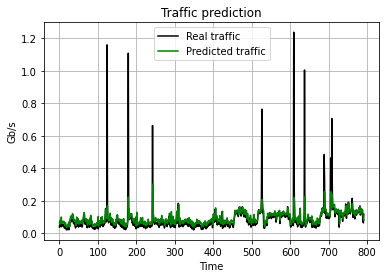

In [ ]:
plt.plot(rem_test, color = 'black', label = 'Real traffic')
plt.plot(predicted_traf, color = 'green', label = 'Predicted traffic')
plt.title('Traffic prediction')
plt.xlabel('Time')
plt.ylabel('Gb/s')
plt.legend()
plt.grid()
plt.show()

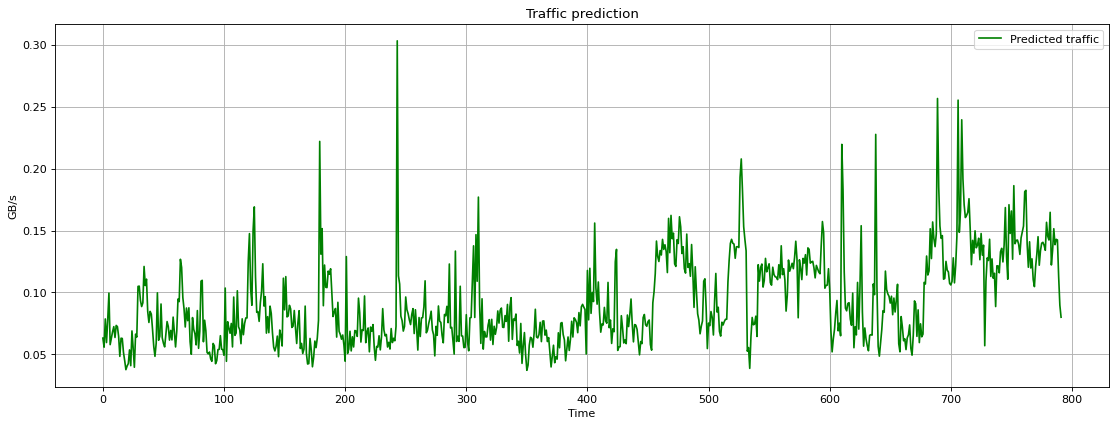

In [ ]:
from matplotlib.pyplot import figure
figure(figsize=(17, 6), dpi=80)

plt.plot(predicted_traf, color = 'green', label = 'Predicted traffic')
plt.title('Traffic prediction')
plt.xlabel('Time')
plt.ylabel('GB/s')
plt.legend()
plt.grid()
plt.show()

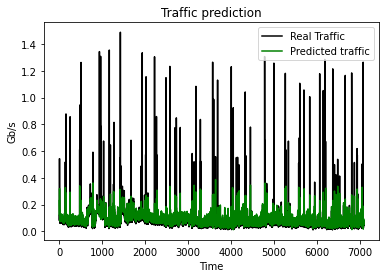

In [ ]:
training_preds = model.predict(X_train)
to_disp = training_set[36:]

plt.plot(to_disp, color = 'black', label = 'Real Traffic')
plt.plot(training_preds, color = 'green', label = 'Predicted traffic')
plt.title('Traffic prediction')
plt.xlabel('Time')
plt.ylabel('Gb/s')
plt.legend()
plt.show()

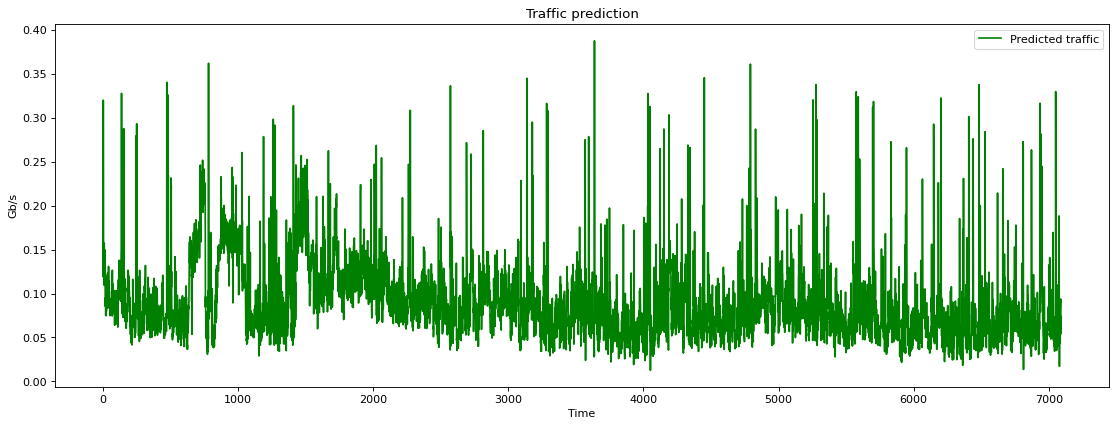

In [ ]:
from matplotlib.pyplot import figure
figure(figsize=(17, 6), dpi=80)

plt.plot(training_preds, color = 'green', label = 'Predicted traffic')
plt.title('Traffic prediction')
plt.xlabel('Time')
plt.ylabel('Gb/s')
plt.legend()
plt.show()

**Predicting multiple times ahead**

In [ ]:
WINDOW_SIZE = 54 #Hány perc alapján (perc = WINDOW_SIZE/2)
PRED_SIZE = 4 #Hány percet (perc = PRED_SIZE/2)
X_train_multi = []
y_train_multi = []

for i in range(WINDOW_SIZE,len(training_set)-PRED_SIZE):
  X_train_multi.append(training_set[i-WINDOW_SIZE:i, 0])
  y_train_multi.append(training_set[i:i+PRED_SIZE, 0])

X_train_multi, y_train_multi = np.array(X_train_multi), np.array(y_train_multi)
X_train_multi = np.reshape(X_train_multi, (X_train_multi.shape[0], X_train_multi.shape[1], 1))

In [ ]:
model = keras.models.Sequential([
    keras.layers.LSTM(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.Dropout(0.2),
    keras.layers.LSTM(20),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(PRED_SIZE)
])

model.compile(optimizer = 'adam', loss = 'mean_squared_error')
model.fit(X_train_multi, y_train_multi, epochs = 60)

Epoch 1/60
221/221 [==============================] - 13s 43ms/step - loss: 0.0102
Epoch 2/60
221/221 [==============================] - 10s 44ms/step - loss: 0.0099
Epoch 3/60
221/221 [==============================] - 10s 44ms/step - loss: 0.0098
Epoch 4/60
221/221 [==============================] - 10s 44ms/step - loss: 0.0098
Epoch 5/60
221/221 [==============================] - 9s 43ms/step - loss: 0.0097
Epoch 6/60
221/221 [==============================] - 10s 43ms/step - loss: 0.0097
Epoch 7/60
221/221 [==============================] - 10s 43ms/step - loss: 0.0097
Epoch 8/60
221/221 [==============================] - 9s 43ms/step - loss: 0.0097
Epoch 9/60
221/221 [==============================] - 9s 43ms/step - loss: 0.0096
Epoch 10/60
221/221 [==============================] - 9s 43ms/step - loss: 0.0096
Epoch 11/60
221/221 [==============================] - 9s 43ms/step - loss: 0.0096
Epoch 12/60
221/221 [==============================] - 9s 43ms/step - loss: 0.0095
Epoch 1

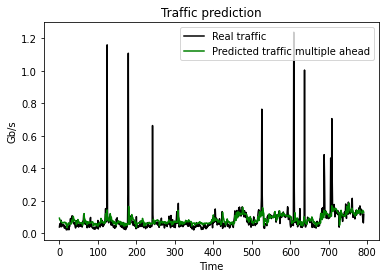

In [ ]:
window = [X_train_multi[-1]]
window = np.array(window)
preds = []
rem_test = dataset_test.values # remaining_test_set
rem_test = np.reshape(rem_test, (-1, 1))

for i in range(0, int(len(rem_test)/PRED_SIZE)):
  actual_pred = model.predict(window)
  preds.append(actual_pred.flatten())

  actual_pred = actual_pred.flatten()
  window = window.flatten()

  window = window[PRED_SIZE:]
  window = window.tolist()
  flat_rem = rem_test.flatten()
  for el in range(0, PRED_SIZE):
    window.append(flat_rem[i*PRED_SIZE + el])
  

  window = np.array(window)
  window = np.reshape(window, (-1,1))
  window = np.reshape(window, (window.shape[1], window.shape[0],1))

preds = np.array(preds).flatten()


plt.plot(rem_test[:len(preds)], color = 'black', label = 'Real traffic')
plt.plot(preds, color = 'green', label = 'Predicted traffic multiple ahead')
plt.title('Traffic prediction')
plt.xlabel('Time')
plt.ylabel('Gb/s')
plt.legend()
plt.show()

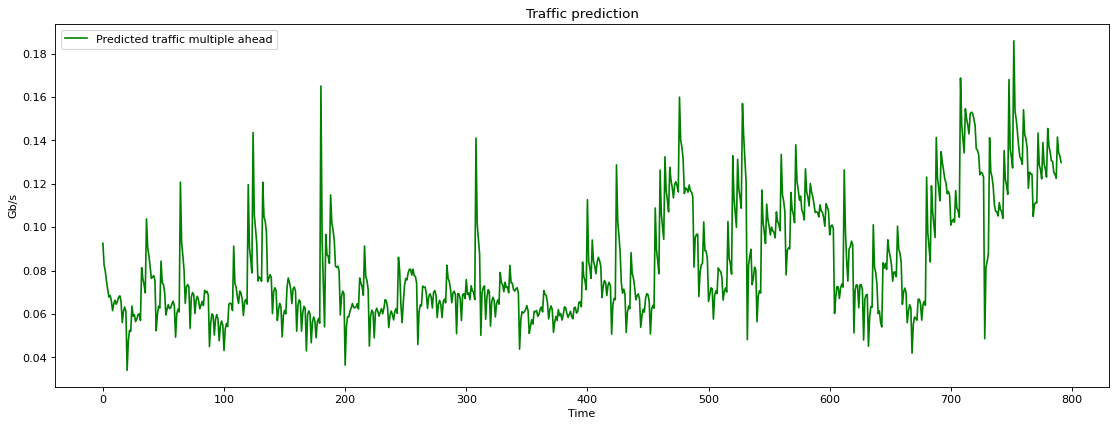

In [ ]:
from matplotlib.pyplot import figure
figure(figsize=(17, 6), dpi=80)
plt.plot(preds, color = 'green', label = 'Predicted traffic multiple ahead')
plt.title('Traffic prediction')
plt.xlabel('Time')
plt.ylabel('Gb/s')
plt.legend()
plt.show()

Itt lényegében az történt, hogy 4 egységgel, (2 perccel) előre jelzett a modell. A 2 db spike azért itt is megfigyelhető (150 környékén, ill. 250 előtt.)



**Error measure**

Mivel ez a fajta hozzáállás vált be eddig a legjobban (lásd később a többit), mérjük meg ezen, hogy milyen átlagos hibát vétünk ahogy egyre messzebb próbálunk a jövőbe jósolni

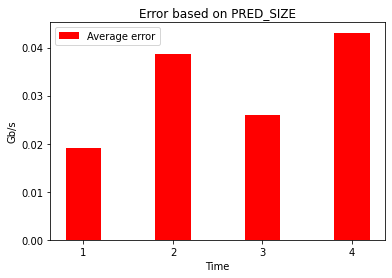

In [ ]:
tot_errors = [0, 0, 0, 0] # Hibak summaja 1,2,3,4 elorejelzesre

flat_test = rem_test.flatten() # az egesz teszt halmaz "kilapitva"

for i, val in enumerate(flat_test):
  tot_errors[i % PRED_SIZE] += abs(preds[i] - val)

for i, val in enumerate(tot_errors):
  tot_errors[i] /= len(preds)/PRED_SIZE

plt.bar([1,2,3,4], tot_errors, width=0.4, color = 'red', label = 'Average error', tick_label=[1,2,3,4])
plt.title('Error based on PRED_SIZE')
plt.xlabel('Time')
plt.ylabel('Gb/s')
plt.legend()
plt.show()

4 egységnél annyira még nem figyelhető meg egy konkrét trend, de az már ezen is látható, hogy növekszik a hibák mértéke ahogy minél távolabb próbálunk előrejelezni, a 4-1 között, kb 2x-re nőtt a hiba átlagos mértéke.

Ahhoz, hogy ne kelljen mindig megvárni egy előrejelzett időablak végét az újabb előrejelzésig, és, hogy egyesével ahogy érkeznek az új valódi értékek előrejelezhessünk, átlagoljuk az értékeket amiket az egyes időpillanatok kapnak az előrejelzések során.

Minden időpillanat 4 szavazatot fog kapni ahogy telik az idő (legelőször úgy, hogy 4 egységgel előre jelzik, aztán úgy, hogy hárommal előre, stb...)- kivéve az első és utolsó 4 időpillanat.

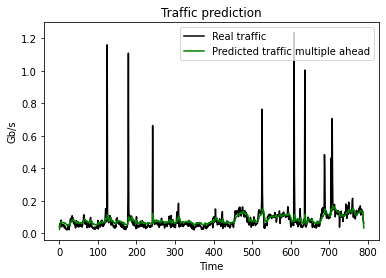

In [ ]:
window = [X_train_multi[-1]]
window = np.array(window)
preds = [0] * (PRED_SIZE-1) # Igy kell inicializalva
rem_test = dataset_test.values # remaining_test_set
rem_test = np.reshape(rem_test, (-1, 1))
for i in range(0, len(rem_test)-PRED_SIZE):
  actual_pred = model.predict(window)
  actual_pred = actual_pred.flatten()

  preds.append(actual_pred[-1]) # A 4. idopillanatot hozzafuzzuk ez teljesen uj elem
  for j in range(0, PRED_SIZE-1):
    preds[-PRED_SIZE+j] += actual_pred[j] # A tobbit pedig rendre hozzaadjuk

  window = window.flatten()

  window = window[1:]
  window = window.tolist()
  window.append(rem_test.flatten()[i])
  

  window = np.array(window)
  window = np.reshape(window, (-1,1))
  window = np.reshape(window, (window.shape[1], window.shape[0],1))

preds = np.array(preds).flatten()
preds = list(map(lambda x: x/PRED_SIZE, preds)) # Atlagoljuk, az elso es utolso 4 ertek nagyon alacsonyan lesz, mert nem ennyivel kene osztani, egyszeruseg kedveert van igy
#Az atlagolas azert kellett, mert mindegyikre 4 szavazat erkezett ahogy haladt az ido (4.-ként, 3.-ként, stb...)- kiveve az elso es utolso 4 erteket

plt.plot(rem_test[:len(preds)], color = 'black', label = 'Real traffic')
plt.plot(preds, color = 'green', label = 'Predicted traffic multiple ahead')
plt.title('Traffic prediction')
plt.xlabel('Time')
plt.ylabel('Gb/s')
plt.legend()
plt.show()

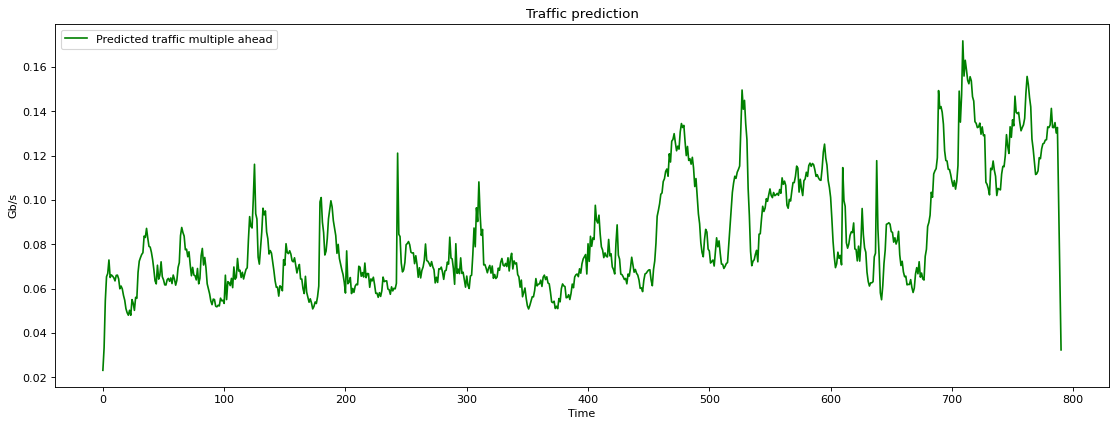

In [ ]:
figure(figsize=(17, 6), dpi=80)
plt.plot(preds, color = 'green', label = 'Predicted traffic multiple ahead')
plt.title('Traffic prediction')
plt.xlabel('Time')
plt.ylabel('Gb/s')
plt.legend()
plt.show()

Emberi szemmel felfedezhető a 2 db spike, itt inkább a hegyességükkel tűnnek ki, mint az értékükkel, az átlagolás miatt, ez egy jóval simább görbe, amiben a hegyes kiszögellések utalnak a spikeokra.

Módosítsuk a módszert, és vezessünk be súlyozást. Amikor egy adott időpillanatot úgy jósolunk, hogy az eggyel van előrébb, mint az időablak akkor kapjon nagyobb súlyt a szavazata, mint amikor mondjuk hárommal vagy néggyel előre jósoljuk, mivel minél kevesebbbel jóslunk előre, annál pontosabb a jóslás.
A súlyok legyenek a következők: j: hány időegységgel előre kapja a szavazatát éppen az időpillanat súly(j)= 1/j
Tehát ha 4 egységgel jelzünk előre a súlyok: 1, 1/2, 1/3, 1/4 (szumma 2.08 körül)

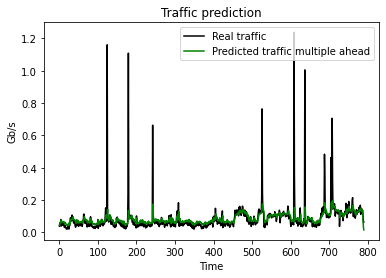

In [ ]:
window = [X_train_multi[-1]]
window = np.array(window)
preds_w = [0] * (PRED_SIZE-1) # Igy kell inicializalva
rem_test = dataset_test.values # remaining_test_set
rem_test = np.reshape(rem_test, (-1, 1))
for i in range(0, len(rem_test)-PRED_SIZE):
  actual_pred = model.predict(window)
  actual_pred = actual_pred.flatten()

  preds_w.append(actual_pred[-1] * (1/4)) # A 4. idopillanatot hozzafuzzuk ez teljesen uj elem, sulyozva
  for j in range(0, PRED_SIZE-1):
    preds_w[-PRED_SIZE+j] += actual_pred[j] * (1/(j+1)) # A tobbit pedig rendre hozzaadjuk sulyozva

  window = window.flatten()

  window = window[1:]
  window = window.tolist()
  window.append(rem_test.flatten()[i])
  

  window = np.array(window)
  window = np.reshape(window, (-1,1))
  window = np.reshape(window, (window.shape[1], window.shape[0],1))

preds_w = np.array(preds_w).flatten()
preds_w = list(map(lambda x: x/2.08, preds_w)) # Atlagoljuk, az elso es utolso 4 ertek nagyon alacsonyan lesz, mert nem ennyivel kene osztani, egyszeruseg kedveert van igy

plt.plot(rem_test[:len(preds)], color = 'black', label = 'Real traffic')
plt.plot(preds_w, color = 'green', label = 'Predicted traffic multiple ahead')
plt.title('Traffic prediction')
plt.xlabel('Time')
plt.ylabel('Gb/s')
plt.legend()
plt.show()

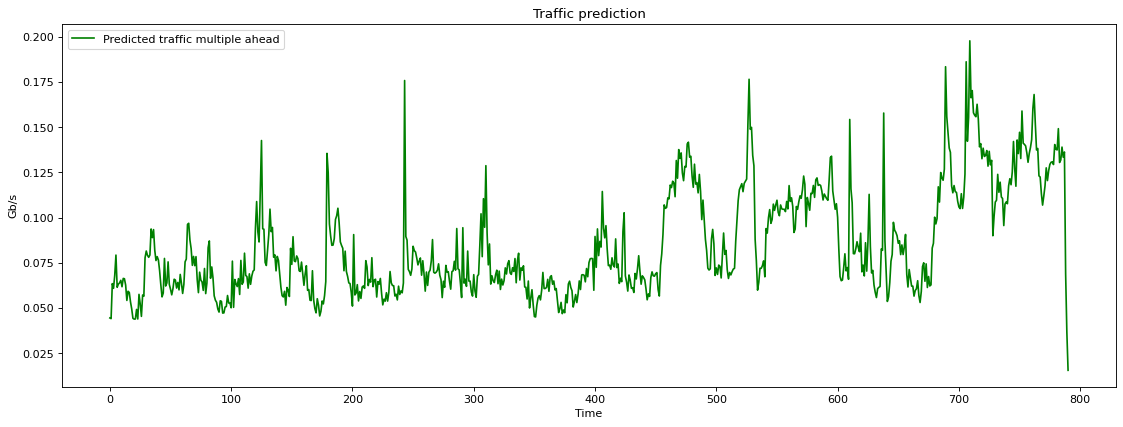

In [ ]:
figure(figsize=(17, 6), dpi=80)
plt.plot(preds_w, color = 'green', label = 'Predicted traffic multiple ahead')
plt.title('Traffic prediction')
plt.xlabel('Time')
plt.ylabel('Gb/s')
plt.legend()
plt.show()

Így pedig a spikeok is sokkal szembetűnőbben látszanak, és azt is megoldottuk, hogy minden bejövő új időpillanat után jósoljunk.

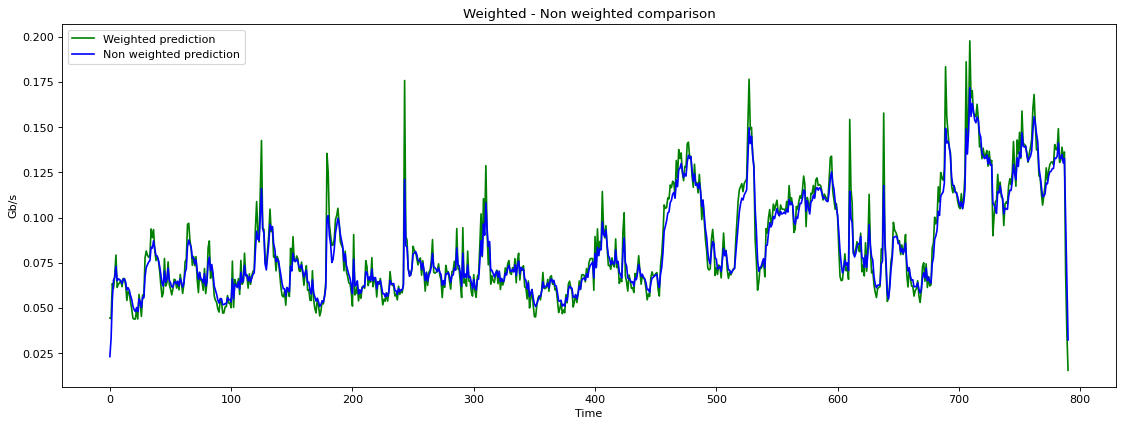

In [ ]:
figure(figsize=(17, 6), dpi=80)
plt.plot(preds_w, color = 'green', label = 'Weighted prediction')
plt.plot(preds, color = 'blue', label = 'Non weighted prediction')
plt.title('Weighted - Non weighted comparison')
plt.xlabel('Time')
plt.ylabel('Gb/s')
plt.legend()
plt.show()

# Más megközelítések
(Az elnevezések saját szülemények)

**Single multiple ahead**

Eddig az előrejelzés úgy nézett ki, hogy egy adott időablak alapján ( és a múltban történtek alapján) a következő 4 időegységet (mind a négyet!) előrejelezte a modell.  Ezért (hogy kirajzolható legyen az előrejelzés és ne legyenek átfedések az előrejelzésben) az előrejelzés után megvártuk a következő 4 igazi értéket (amit éppen megpróbáltunk előrejelezni), majd csak ezután jósoltunk újra. (megj: Az átlagolással, és súlyozással időközben ez is megoldódott.)

Mi lenne ha nem mind a négyet jeleznénk előre, hanem csak(!) a negyediket? Így egy előrejelzés után nem kéne megvárni a következő pl. 4 időegységet amíg újra előrejelzünk, hanem ahogy kapjuk a következő és következő valódi értéket, tudjuk is előrejelzni, hogy mi lesz 4 időegység múlva.

In [ ]:
X_train = []
y_train = []
PRED_DIST = 4 # most legyen DIST, nem SIZE, jelezve, hogy 1 db kimenetünk lesz, hogy mi lesz az ertek 4 egyseg mulva

for i in range(36,len(training_set)-PRED_DIST):
  X_train.append(training_set[i-36:i, 0])
  y_train.append(training_set[i+PRED_DIST-1, 0])

X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

In [ ]:
import keras
import keras.models
import keras.layers

model = keras.models.Sequential([
    keras.layers.LSTM(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.Dropout(0.2),
    keras.layers.LSTM(20),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(1)
])

model.compile(optimizer = 'adam', loss = 'mean_squared_error')

In [ ]:
model.fit(X_train, y_train, epochs = 60)

Epoch 1/60
222/222 [==============================] - 11s 31ms/step - loss: 0.0102
Epoch 2/60
222/222 [==============================] - 7s 31ms/step - loss: 0.0100
Epoch 3/60
222/222 [==============================] - 7s 31ms/step - loss: 0.0099
Epoch 4/60
222/222 [==============================] - 7s 31ms/step - loss: 0.0098
Epoch 5/60
222/222 [==============================] - 7s 31ms/step - loss: 0.0099
Epoch 6/60
222/222 [==============================] - 7s 33ms/step - loss: 0.0099
Epoch 7/60
222/222 [==============================] - 7s 31ms/step - loss: 0.0098
Epoch 8/60
222/222 [==============================] - 7s 31ms/step - loss: 0.0098
Epoch 9/60
222/222 [==============================] - 7s 31ms/step - loss: 0.0097
Epoch 10/60
222/222 [==============================] - 7s 31ms/step - loss: 0.0098
Epoch 11/60
222/222 [==============================] - 7s 31ms/step - loss: 0.0097
Epoch 12/60
222/222 [==============================] - 7s 31ms/step - loss: 0.0097
Epoch 13/60


In [ ]:
test_set = training_set[-36-PRED_DIST:]
rem_test = dataset_test.values # remaining_test_set
rem_test = np.reshape(rem_test, (-1, 1))
test_set = np.append(test_set, rem_test)
test_set = np.reshape(test_set, (-1, 1))
X_test = []
for i in range(36, len(test_set)-PRED_DIST):
    X_test.append(test_set[i-36:i, 0])
  
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [ ]:
predicted_traf = model.predict(X_test)

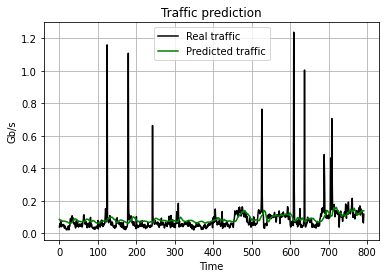

In [ ]:
plt.plot(rem_test, color = 'black', label = 'Real traffic')
plt.plot(predicted_traf, color = 'green', label = 'Predicted traffic')
plt.title('Traffic prediction')
plt.xlabel('Time')
plt.ylabel('Gb/s')
plt.legend()
plt.grid()
plt.show()

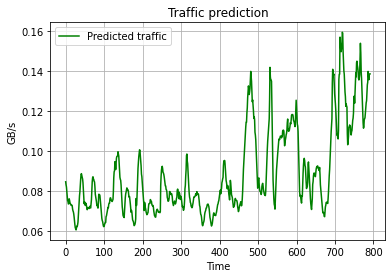

In [ ]:
plt.plot(predicted_traf, color = 'green', label = 'Predicted traffic')
plt.title('Traffic prediction')
plt.xlabel('Time')
plt.ylabel('GB/s')
plt.legend()
plt.grid()
plt.show()

Talán nem szerepel olyan jól, mintha mind a négy időegységet előrejeleznénk.

**Folyamat előrejelzés, de egyesével és csak az utolsó megtartása**

Ebben a "modellben" azt próbáltam ki, hogy az előzőek alapján jelezzük ugyan előre mind a 4 egységet, hiszen az jobban működött, viszont annak érdekében, hogy az újabb és újabb bejövő valódi értékeket rögtön felhasználhassuk és ne várjunk a jelzett időablak végéig, ezért az előrejelzett 4 időegységből csak az utolsót tartsuk meg, így gyakorlatilag megint annyit fogunk látni, hogy egy pontban mi történik majd 4 egység múlva, de ahogy jönnek az újabb valódi értékek fel is tudjuk őket használni.

In [ ]:
WINDOW_SIZE = 54 #Hány perc alapján (perc = WINDOW_SIZE/2)
PRED_SIZE = 4 #Hány percet (perc = PRED_SIZE/2)
X_train_multi = []
y_train_multi = []

for i in range(WINDOW_SIZE,len(training_set)-PRED_SIZE):
  X_train_multi.append(training_set[i-WINDOW_SIZE:i, 0])
  y_train_multi.append(training_set[i:i+PRED_SIZE, 0])

X_train_multi, y_train_multi = np.array(X_train_multi), np.array(y_train_multi)
X_train_multi = np.reshape(X_train_multi, (X_train_multi.shape[0], X_train_multi.shape[1], 1))

In [ ]:
model = keras.models.Sequential([
    keras.layers.LSTM(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.Dropout(0.2),
    keras.layers.LSTM(20),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(PRED_SIZE)
])

model.compile(optimizer = 'adam', loss = 'mean_squared_error')
model.fit(X_train_multi, y_train_multi, epochs = 60)

Epoch 1/60
73/73 [==============================] - 6s 35ms/step - loss: 0.0128
Epoch 2/60
73/73 [==============================] - 3s 36ms/step - loss: 0.0108
Epoch 3/60
73/73 [==============================] - 3s 35ms/step - loss: 0.0105
Epoch 4/60
73/73 [==============================] - 3s 35ms/step - loss: 0.0104
Epoch 5/60
73/73 [==============================] - 3s 36ms/step - loss: 0.0103
Epoch 6/60
73/73 [==============================] - 3s 35ms/step - loss: 0.0102
Epoch 7/60
73/73 [==============================] - 3s 35ms/step - loss: 0.0103
Epoch 8/60
73/73 [==============================] - 3s 35ms/step - loss: 0.0102
Epoch 9/60
73/73 [==============================] - 3s 35ms/step - loss: 0.0101
Epoch 10/60
73/73 [==============================] - 3s 37ms/step - loss: 0.0101
Epoch 11/60
73/73 [==============================] - 3s 36ms/step - loss: 0.0101
Epoch 12/60
73/73 [==============================] - 3s 35ms/step - loss: 0.0101
Epoch 13/60
73/73 [==================

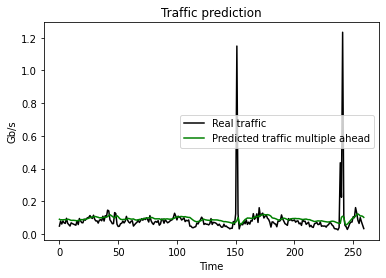

In [ ]:
window = [X_train_multi[-1]]
window = np.array(window)
preds = []
rem_test = dataset_test.values # remaining_test_set
rem_test = np.reshape(rem_test, (-1, 1))

for i in range(0, len(rem_test)-PRED_SIZE):
  actual_pred = model.predict(window)
  preds.append(actual_pred.flatten()[-1])

  actual_pred = actual_pred.flatten()
  window = window.flatten()

  window = window[1:]
  window = window.tolist()
  flat_rem = rem_test.flatten()
  #for el in range(0, PRED_SIZE):
  #  window.append(flat_rem[i*PRED_SIZE + el])
  window.append(flat_rem[i])

  window = np.array(window)
  window = np.reshape(window, (-1,1))
  window = np.reshape(window, (window.shape[1], window.shape[0],1))

preds = np.array(preds).flatten()


plt.plot(rem_test[:len(preds)], color = 'black', label = 'Real traffic')
plt.plot(preds, color = 'green', label = 'Predicted traffic multiple ahead')
plt.title('Traffic prediction')
plt.xlabel('Time')
plt.ylabel('Gb/s')
plt.legend()
plt.show()

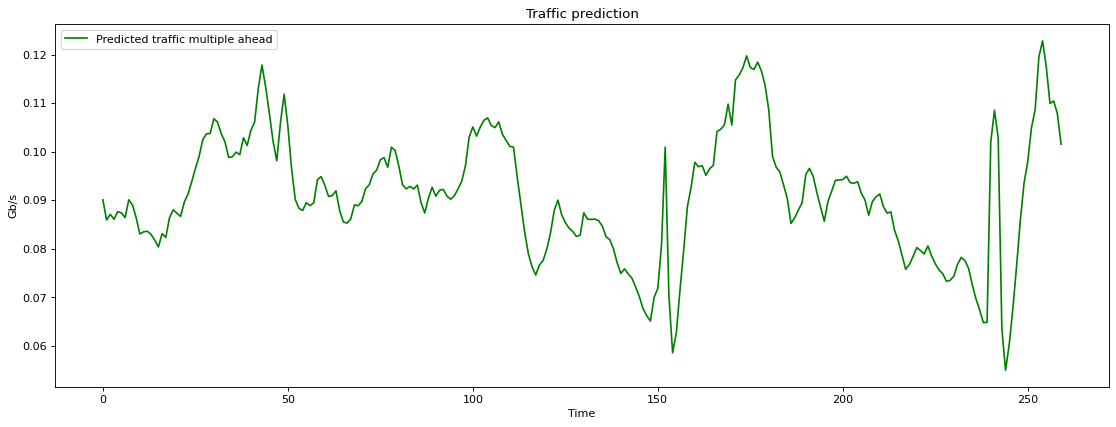

In [ ]:
from matplotlib.pyplot import figure
figure(figsize=(17, 6), dpi=80)
plt.plot(preds, color = 'green', label = 'Predicted traffic multiple ahead')
plt.title('Traffic prediction')
plt.xlabel('Time')
plt.ylabel('Gb/s')
plt.legend()
plt.show()

Ez pedig kifejezetten rosszul teljesít

Mivel eddig úgy néz ki az ment a legjobban ha az előrejelzett ugrás minden egyes elemét jósoljuk, és csak akkor jóslunk újra ha elérünk az előzőleg jósolt sorozat utolsó eleméhez időben, nézzük meg, hogy erre a modellre, hogy változik az átlagos hiba ahogy növeljük az ugrás méretét. (lásd fent)

**Megjegyzés**

A gyakorlatban majd teljesen jól használható lenne a legjobban teljesítő modell úgy is, hogy nem várjuk meg az előrejelzett időablak végét az következő előrejelzésig, hanem minden egyes újonnan bejövő valódi értéknél előrejelezzük az összes értéket. Jelenleg annyi volt a "probléma" ezzel, hogy így egy-egy időpillanatra átfedéseket kaptunk volna (egyszer 4. időpillanatként lett volna előrejósolva, utána már csak 3.-ként, majd 2-ként, stb... ahogy haladunk az időben), ezért a kirajzolása nehézkes lett volna.

**Sequence to sequence model**

A módszer lényege, hogy egy időablakhoz nem az időablak utáni n érték tartozik elvárt kimenetként, hanem, az időablak minden egyes eleme után predikál a modell, és összeveti a valósággal. Így elméletileg gyorsabban konvergál, és jobb teljesítményre képes a model.

In [ ]:
dataset_train

0       0.110819
1       0.089974
2       0.108715
3       0.084453
4       0.088943
          ...   
7123    0.080468
7124    0.045926
7125    0.058625
7126    0.043427
7127    0.044837
Name: out, Length: 7128, dtype: float64

In [ ]:
WINDOW_SIZE = 120
PRED_SIZE = 4

X_train = []

for i in range(WINDOW_SIZE,len(training_set), WINDOW_SIZE):
  X_train.append(training_set[i-WINDOW_SIZE:i, 0])
  

X_train= np.array(X_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

X_train

array([[[0.11081921],
        [0.08997357],
        [0.10871498],
        ...,
        [0.07179114],
        [0.07933739],
        [0.08977195]],

       [[0.09098036],
        [0.07790013],
        [0.05149571],
        ...,
        [0.07546201],
        [0.05804862],
        [0.04041894]],

       [[0.05333243],
        [0.05313589],
        [0.04816486],
        ...,
        [0.07390233],
        [0.06391729],
        [0.05173835]],

       ...,

       [[0.04497451],
        [0.0467355 ],
        [0.03006728],
        ...,
        [0.05083718],
        [0.11577589],
        [0.03839875]],

       [[0.04866473],
        [0.04460175],
        [0.03860552],
        ...,
        [0.0346161 ],
        [0.05856382],
        [0.02615055]],

       [[0.02132031],
        [0.02321472],
        [0.04011054],
        ...,
        [0.028821  ],
        [0.02254186],
        [0.02667072]]])

In [ ]:
flat_train = training_set.flatten()
flat_labels = []
for i, value in enumerate(X_train.flatten()):
  
  flat_labels.append(training_set.flatten()[i+1:i+1+PRED_SIZE])

flat_labels= np.array(flat_labels)
flat_labels = np.reshape(flat_labels, (int(len(X_train.flatten())/WINDOW_SIZE), WINDOW_SIZE, PRED_SIZE))
flat_labels

array([[[0.08997357, 0.10871498, 0.08445323, 0.08894342],
        [0.10871498, 0.08445323, 0.08894342, 0.09483414],
        [0.08445323, 0.08894342, 0.09483414, 0.08394636],
        ...,
        [0.07933739, 0.08977195, 0.09098036, 0.07790013],
        [0.08977195, 0.09098036, 0.07790013, 0.05149571],
        [0.09098036, 0.07790013, 0.05149571, 0.07002928]],

       [[0.07790013, 0.05149571, 0.07002928, 0.06722759],
        [0.05149571, 0.07002928, 0.06722759, 0.08713148],
        [0.07002928, 0.06722759, 0.08713148, 0.05391731],
        ...,
        [0.05804862, 0.04041894, 0.05333243, 0.05313589],
        [0.04041894, 0.05333243, 0.05313589, 0.04816486],
        [0.05333243, 0.05313589, 0.04816486, 0.03571653]],

       [[0.05313589, 0.04816486, 0.03571653, 0.03609921],
        [0.04816486, 0.03571653, 0.03609921, 0.03150431],
        [0.03571653, 0.03609921, 0.03150431, 0.05326539],
        ...,
        [0.06391729, 0.05173835, 0.06742405, 0.04836113],
        [0.05173835, 0.067424

In [ ]:
# Seed value
# Apparently you may use different seed values at each stage
seed_value= 0

# 1. Set the `PYTHONHASHSEED` environment variable at a fixed value
import os
os.environ['PYTHONHASHSEED']=str(seed_value)

# 2. Set the `python` built-in pseudo-random generator at a fixed value
import random
random.seed(seed_value)

# 3. Set the `numpy` pseudo-random generator at a fixed value
import numpy as np
np.random.seed(seed_value)

# 4. Set the `tensorflow` pseudo-random generator at a fixed value
import tensorflow as tf
tf.random.set_seed(seed_value)
# for later versions: 
# tf.compat.v1.set_random_seed(seed_value)

# 5. Configure a new global `tensorflow` session
from keras import backend as K
session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
tf.compat.v1.keras.backend.set_session(sess)

In [ ]:
import keras
import keras.models
import keras.layers

model = keras.models.Sequential([
    keras.layers.LSTM(20, return_sequences=True, input_shape=[None, 1]),
    #keras.layers.Dropout(0.2),
    keras.layers.LSTM(20, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(PRED_SIZE))

])

model.compile(optimizer = 'adam', loss = 'mean_squared_error')

In [ ]:
model.fit(X_train, flat_labels, epochs = 400)

Epoch 1/400
2/2 [==============================] - 3s 91ms/step - loss: 0.0177
Epoch 2/400
2/2 [==============================] - 0s 91ms/step - loss: 0.0152
Epoch 3/400
2/2 [==============================] - 0s 85ms/step - loss: 0.0131
Epoch 4/400
2/2 [==============================] - 0s 91ms/step - loss: 0.0115
Epoch 5/400
2/2 [==============================] - 0s 87ms/step - loss: 0.0106
Epoch 6/400
2/2 [==============================] - 0s 94ms/step - loss: 0.0104
Epoch 7/400
2/2 [==============================] - 0s 83ms/step - loss: 0.0105
Epoch 8/400
2/2 [==============================] - 0s 96ms/step - loss: 0.0105
Epoch 9/400
2/2 [==============================] - 0s 88ms/step - loss: 0.0103
Epoch 10/400
2/2 [==============================] - 0s 86ms/step - loss: 0.0101
Epoch 11/400
2/2 [==============================] - 0s 94ms/step - loss: 0.0101
Epoch 12/400
2/2 [==============================] - 0s 87ms/step - loss: 0.0101
Epoch 13/400
2/2 [==============================]

Miért csak 2 batch-el dolgozik? (Vagy épp 1-el?)

In [ ]:
test_set = X_train[-1].flatten().tolist() + dataset_test.values.flatten().tolist()
#test_set = np.reshape(test, (1, WINDOW_SIZE, 1))
test_set = np.reshape(test_set, (-1, 1))
len(test_set)

912

In [ ]:
X_test = []

for i in range(WINDOW_SIZE,len(test_set)-PRED_SIZE, PRED_SIZE):
  X_test.append(test_set[i-WINDOW_SIZE:i, 0])

#X_test = X_test.flatten()
X_test = np.reshape(X_test, (len(X_test),WINDOW_SIZE,1))
X_test

array([[[0.02132031],
        [0.02321472],
        [0.04011054],
        ...,
        [0.028821  ],
        [0.02254186],
        [0.02667072]],

       [[0.02230091],
        [0.04963397],
        [0.04525484],
        ...,
        [0.05747538],
        [0.04131068],
        [0.05683347]],

       [[0.05592114],
        [0.07129653],
        [0.61894061],
        ...,
        [0.03948146],
        [0.04408812],
        [0.04919621]],

       ...,

       [[0.04105619],
        [0.03565211],
        [0.06012088],
        ...,
        [0.12133209],
        [0.13462705],
        [0.13600032]],

       [[0.04275116],
        [0.04357187],
        [0.0358599 ],
        ...,
        [0.1253236 ],
        [0.1559762 ],
        [0.14647286]],

       [[0.04596653],
        [0.05331665],
        [0.0363218 ],
        ...,
        [0.16831763],
        [0.11174454],
        [0.11801403]]])

In [ ]:
model.predict(X_test)

array([[[0.05803774, 0.05744228, 0.06453617, 0.06570829],
        [0.06650773, 0.07002489, 0.07606386, 0.07740378],
        [0.07052116, 0.07739574, 0.08090568, 0.08328825],
        ...,
        [0.05356619, 0.0604855 , 0.06389084, 0.06633563],
        [0.05016761, 0.05718515, 0.05979108, 0.0629712 ],
        [0.04792042, 0.05456328, 0.05646288, 0.06004423]],

       [[0.05819767, 0.05752713, 0.0646223 , 0.06575849],
        [0.07110985, 0.07248613, 0.07854543, 0.07888004],
        [0.07598297, 0.08071218, 0.08402289, 0.0854841 ],
        ...,
        [0.05247554, 0.05485416, 0.05536645, 0.05791603],
        [0.0533666 , 0.05498528, 0.05481774, 0.0574576 ],
        [0.0560069 , 0.0563052 , 0.05566422, 0.05791056]],

       [[0.06363585, 0.06039745, 0.06752075, 0.06744646],
        [0.08024153, 0.07776979, 0.08360863, 0.08225138],
        [0.16652426, 0.12562042, 0.12387549, 0.11016308],
        ...,
        [0.06063271, 0.05963539, 0.05845511, 0.06029847],
        [0.05869685, 0.059113

In [ ]:
preds = []
for pred in model.predict(X_test):
  preds.append(pred[-1])
preds = np.array(preds)
preds

array([[0.04792042, 0.05456328, 0.05646288, 0.06004423],
       [0.0560069 , 0.0563052 , 0.05566422, 0.05791056],
       [0.05817361, 0.05911154, 0.05879569, 0.06079786],
       [0.06010513, 0.06060649, 0.06203836, 0.06284365],
       [0.05505392, 0.05748906, 0.05993504, 0.06130631],
       [0.04437372, 0.04978509, 0.05270873, 0.05563291],
       [0.04479501, 0.04720661, 0.04966465, 0.05195887],
       [0.04752744, 0.04817919, 0.05006815, 0.05207166],
       [0.06956367, 0.06351288, 0.06419669, 0.06367379],
       [0.08403219, 0.07644293, 0.07845497, 0.07602194],
       [0.07463583, 0.07450909, 0.07888561, 0.07797821],
       [0.05973199, 0.064749  , 0.06917509, 0.07062989],
       [0.06502088, 0.06532992, 0.06727548, 0.06810962],
       [0.05745119, 0.06034322, 0.06160112, 0.06382905],
       [0.05912945, 0.06048191, 0.06150383, 0.06314752],
       [0.05797058, 0.05966615, 0.0609458 , 0.06264052],
       [0.07690555, 0.07025821, 0.07106566, 0.06921889],
       [0.07620132, 0.07509585,

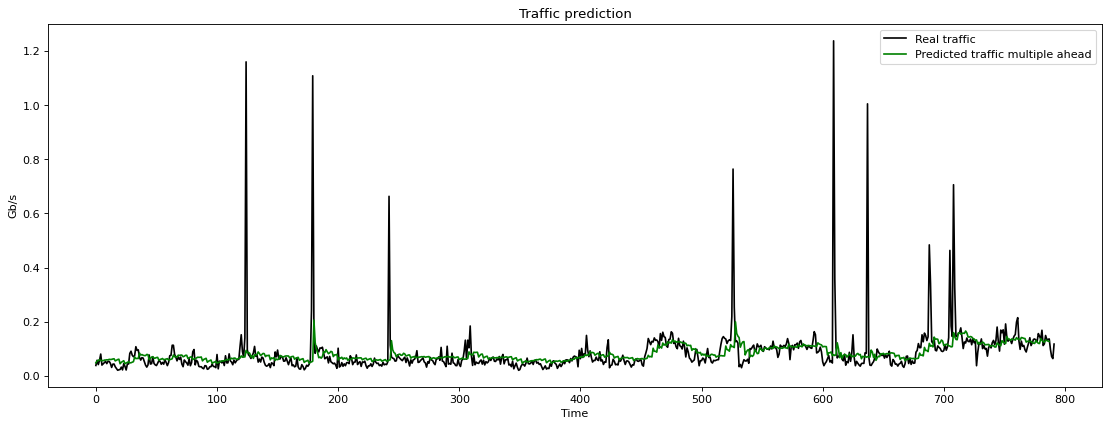

In [ ]:
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
figure(figsize=(17, 6), dpi=80)
plt.plot(dataset_test.values, color = 'black', label = 'Real traffic')
plt.plot(preds.flatten(), color = 'green', label = 'Predicted traffic multiple ahead')
plt.title('Traffic prediction')
plt.xlabel('Time')
plt.ylabel('Gb/s')
plt.legend()
plt.show()

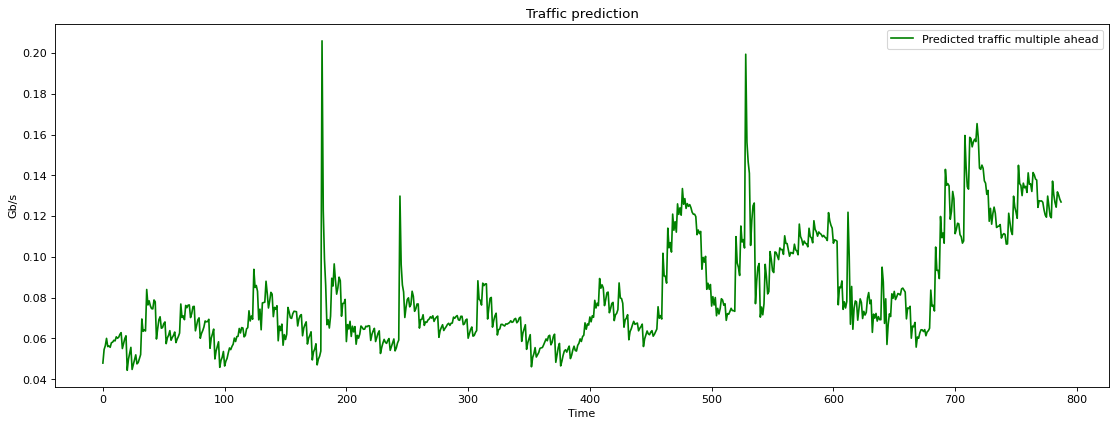

In [ ]:
figure(figsize=(17, 6), dpi=80)
plt.plot(preds.flatten(), color = 'green', label = 'Predicted traffic multiple ahead')
plt.title('Traffic prediction')
plt.xlabel('Time')
plt.ylabel('Gb/s')
plt.legend()
plt.show()